# Model calibration via MCMC sampling

This notebook implements the Metropolis-Hastings MCMC algorithm via the `pymc` package to infer posterior distributions of wall decay coefficients in the Bristol Water Field Lab. It employs a GP surrogate model in place of the (expensive) EPANET water quality simulator (see `04-GP_surrogate_modelling.ipynb`) and field data organized in `01-data-period-features.ipynb`.

In [1]:
import pandas as pd
import numpy as np
import joblib
from scipy.stats import truncnorm, triang, uniform, norm
from tqdm.notebook import tqdm
import pytensor.tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph.op import Op
import pymc as pm
import arviz as az

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.colors
default_colors = plotly.colors.qualitative.Plotly
import matplotlib.pyplot as plt

from bayesian_wq_calibration.constants import TIMESERIES_DIR, RESULTS_DIR
from bayesian_wq_calibration.calibration import decision_variables_to_dict
from bayesian_wq_calibration.epanet import build_model, epanet_simulator, sensor_model_id
from bayesian_wq_calibration.data import bulk_temp_adjust

### Load data

Load operational data for selected sensing period.

In [2]:
data_period = 18 # 20 calibration events (as at 30 October 2024)
wq_sensors_used = 'kiosk + hydrant' # 'kiosk only', 'kiosk + hydrant'
demand_resolution = 'wwmd' # 'dma', 'wwmd'

try:
    wq_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-wq.csv", low_memory=False)
    cl_df = wq_df[wq_df['data_type'] == 'chlorine']
    
except FileNotFoundError:
    print(f"Data period {data_period} does not exist.")

Set modelling parameters.

In [3]:
sim_days = 5  # must match number of days used to train GP model
time_steps = sim_days * 24 * 4
datetime_vals = cl_df['datetime'].unique()
datetime_subset = datetime_vals[:time_steps]
cl_df = cl_df[cl_df['datetime'].isin(datetime_subset)]

source_ids = ['BW1', 'BW4']
kiosk_ids = ['BW1', 'BW2', 'BW4', 'BW5', 'BW9', 'BW12']
bad_ids = ['BW7']
if wq_sensors_used == 'kiosk only':
    cl_df = cl_df[(cl_df['bwfl_id'].isin(kiosk_ids)) & (~cl_df['bwfl_id'].isin(source_ids)) & (~cl_df['bwfl_id'].isin(bad_ids))]
else:
    cl_df = cl_df[(~cl_df['bwfl_id'].isin(source_ids)) & (~cl_df['bwfl_id'].isin(bad_ids))]
sensor_names = cl_df['bwfl_id'].unique()
demand_resolution = 'wwmd' # 'dma', 'wwmd'

Bulk decay.

In [4]:
bulk_coeff = -0.7 # day^-1 (from bottle tests)
field_temp = wq_df[wq_df['data_type'] == 'temperature']['mean'].mean()
bulk_coeff = bulk_temp_adjust(bulk_coeff, field_temp)
bulk_uncertainty = 0.05
bulk_coeff_bounds = (bulk_coeff*(1+bulk_uncertainty*5), bulk_coeff*(1-bulk_uncertainty*5))

Wall decay grouping.

In [5]:
# see notebook `02-pipe-grouping-exploration.ipynb` for details on pipe groups
grouping = 'material-age-velocity'

# load ga results to get param_mean data
ga_results_df = pd.read_excel(RESULTS_DIR / 'wq/ga_calibration.xlsx', sheet_name=grouping)
ga_results_df = ga_results_df[(ga_results_df['data_period'] == data_period) & (ga_results_df['demand_resolution'] == demand_resolution) & (ga_results_df['wq_sensors_used'] == wq_sensors_used)]
ga_results = ga_results_df[[col for col in ga_results_df.columns if col.startswith('G')]].values[0]

grouping_data = {
    'single': {
        'param_group': ['B', 'W0'],
        'param_bounds': [bulk_coeff_bounds, (-0.5, 0.0)],
        'param_mean': np.concatenate([[bulk_coeff], ga_results])
    },
    'material-only': {
        'param_group': ['B', 'W0', 'W1'],
        'param_bounds': [bulk_coeff_bounds, (-1.0, -0.01), (-0.5, -0.01), (-0.15, -0.01)],
        'param_mean': np.concatenate([[bulk_coeff], ga_results])
    },
    'material-age-diameter': {
        'param_group': ['B', 'W0', 'W1', 'W2', 'W3', 'W4'],
        'param_bounds': [bulk_coeff_bounds, (-1.0, -0.01), (-1.0, -0.01), (-0.5, -0.01), (-0.5, -0.01), (-0.2, -0.01)],
        'param_mean': np.concatenate([[bulk_coeff], ga_results])
    },
    'material-age-velocity': {
        'param_group': ['B', 'W0', 'W1', 'W2', 'W3', 'W4'],
        'param_bounds': [bulk_coeff_bounds, (-1.0, -0.01), (-1.0, -0.01), (-0.5, -0.01), (-0.5, -0.01), (-0.2, -0.01)],
        'param_mean': np.concatenate([[bulk_coeff], ga_results])
    }
}

param_data = grouping_data[grouping]
param_group = param_data['param_group']
param_bounds = param_data['param_bounds']
param_mean = param_data['param_mean']

### MCMC algorithm

Define functions here. (To be moved to `src` folder at a later date.)

In [9]:
def load_gp_models(sensor_names, demand_resolution, sim_days):
    """Load saved GP models"""
    model_dir = RESULTS_DIR / 'wq/gp_models'
    model_dir.mkdir(parents=True, exist_ok=True)
    gp_models = {}
    
    for sensor in sensor_names:
        filename = f'gp_{data_period}_{sensor}_{demand_resolution}_{sim_days}-day_sim.joblib'
        model_path = model_dir / filename
        gp_models[sensor] = joblib.load(model_path)
    
    return gp_models


class GPLikelihood(Op):
    """Custom PyTensor Op for GP likelihood calculation"""
    
    def __init__(self, gp_models, cl_df):
        self.gp_models = gp_models
        self.cl_df = cl_df
        
    def make_node(self, theta, noise_std):
        # Convert inputs to tensors
        theta = pt.as_tensor_variable(theta)
        noise_std = pt.as_tensor_variable(noise_std)
        
        # Define output type (scalar log likelihood)
        return Apply(self, [theta, noise_std], [pt.scalar()])
    
    def perform(self, node, inputs, outputs):
        theta, noise_std = inputs
        
        # Calculate log likelihood
        log_l = 0
        theta_1d = theta.reshape(1, -1)
        
        for sensor in self.gp_models:
            sensor_data = self.cl_df.loc[self.cl_df['bwfl_id'] == sensor, 'mean'].values
            mask = ~np.isnan(sensor_data) & (np.arange(len(sensor_data)) >= 96)
            observed = sensor_data[mask]
            
            theta_scaled = self.gp_models[sensor]['scaler'].transform(theta_1d)
            predicted = self.gp_models[sensor]['gp_model'].predict(theta_scaled).T.ravel()[mask]
            
            # Calculate log likelihood using normal distribution
            log_l += norm.logpdf(observed, predicted, noise_std).sum()
        
        outputs[0][0] = np.array(log_l, dtype='float64')


def custom_loglike(observed, theta, noise_std, gp_likelihood_op):
    """Custom likelihood function for PyMC"""
    return gp_likelihood_op(theta, noise_std)


def mcmc_pymc(gp_models, cl_df, prior_params, n_iter=10000, noise_std=0.1, burn_in=1000):
    """Run MCMC using PyMC with custom likelihood"""
    
    # create GP likelihood op
    gp_likelihood_op = GPLikelihood(gp_models, cl_df)
    
    with pm.Model() as model:
        
        # define priors
        theta = [
            pm.TruncatedNormal(
                f'theta_{i}',
                mu=prior['mu'],
                sigma=abs(prior['mu'] * prior['rel_uncertainty']),
                lower=prior['lower_bound'],
                upper=prior['upper_bound']
            )
            for i, prior in enumerate(prior_params)
        ]
        
        # stack parameters into a vector
        theta_vector = pt.stack(theta)
        
        # add likelihood using CustomDist
        likelihood = pm.CustomDist(
            'likelihood',
            theta_vector,
            noise_std,
            observed=np.array([0.0]),  # Dummy observed value
            logp=lambda observed, theta, noise_std: custom_loglike(
                observed, theta, noise_std, gp_likelihood_op
            )
        )
        
        # run sampling with Metropolis
        idata = pm.sample(
            draws=n_iter,
            tune=burn_in,
            step=pm.Metropolis(tune=True),
            return_inferencedata=True,
            progressbar=True,
            chains=4,
            # cores=1
        )
    
    return idata

def plot_mcmc_traces(trace, param_names=None, text_size=12, v_space=0.15, h_space=0.2):
    """create interactive trace plots using plotly"""
    
    # if parameter names not provided, extract from trace
    if param_names is None:
        param_names = [var for var in trace.posterior.variables if var.startswith('theta')]
    
    n_params = len(param_names)
    
    # create subplots with corrected titles
    subplot_titles = []
    for i in range(n_params):
        subplot_titles.extend([f"theta_{i} distribution", f"theta_{i} trace"])
    
    fig = make_subplots(
        rows=n_params, 
        cols=2,
        subplot_titles=subplot_titles,
        vertical_spacing=v_space,  # controllable vertical spacing
        horizontal_spacing=h_space  # controllable horizontal spacing
    )
    
    # add traces for each parameter
    for i, param in enumerate(param_names, 1):
        # get values for this parameter
        values = trace.posterior[param].values.flatten()
        iterations = np.arange(len(values))
        
        # add histogram
        fig.add_trace(
            go.Histogram(
                x=values,
                name=f"{param} Distribution",
                nbinsx=50,
                showlegend=False,
                marker_color=default_colors[0]
            ),
            row=i, col=1
        )
        
        # add trace plot in grey
        fig.add_trace(
            go.Scatter(
                x=iterations,
                y=values,
                mode='lines',
                name=f"{param} Trace",
                showlegend=False,
                line=dict(color=default_colors[0])
            ),
            row=i, col=2
        )
    
    # update layout
    fig.update_layout(
        height=300 * n_params,
        width=1000,
        title_text="MCMC summary plots",
        showlegend=False,
        template='simple_white'
    )
    
    # update font sizes for subplot titles
    for annotation in fig['layout']['annotations']:
       annotation['font'] = dict(size=text_size + 1)  # subplot titles slightly larger than base
    
    # update axes labels and tick font sizes
    for i in range(n_params):
       # distribution plot
       fig.update_xaxes(
           title_text="Value",
           title_font=dict(size=text_size),
           tickfont=dict(size=text_size),
           row=i+1, col=1
       )
       fig.update_yaxes(
           title_text="Count",
           title_font=dict(size=text_size),
           tickfont=dict(size=text_size),
           row=i+1, col=1
       )
       
       # trace plot
       fig.update_xaxes(
           title_text="Iteration",
           title_font=dict(size=text_size),
           tickfont=dict(size=text_size),
           row=i+1, col=2
       )
       fig.update_yaxes(
           title_text="Value",
           title_font=dict(size=text_size),
           tickfont=dict(size=text_size),
           row=i+1, col=2
       )
    return fig


def propose_first_parameter(idx, current_param, dist_type, bulk_uncertainty, wall_uncertainty, param_bounds):

    sample = np.random.random()
    
    if idx == 0:
        sigma = abs(current_param * bulk_uncertainty)
        return norm.ppf(sample, loc=current_param, scale=sigma)
    else:
        sigma = abs(current_param * wall_uncertainty)
        lb = param_bounds[0]
        ub = param_bounds[1]

        if dist_type == 'truncated normal':
            a = (lb - current_param) / sigma
            b = (ub - current_param) / sigma
            return truncnorm.ppf(sample, a=a, b=b, loc=current_param, scale=sigma)
            
        elif dist_type == 'triangle':
            c = (current_param - lb) / (ub - lb)
            return triang.ppf(sample, c=c, loc=lb, scale=ub-lb)
            
        elif dist_type == 'uniform':
            return uniform.ppf(sample, loc=lb, scale=ub-lb)
        
        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")


def propose_next_parameter(current_param, step_size):

    sample = np.random.random()
    sigma = abs(current_param * step_size)
    return norm.ppf(sample, loc=current_param, scale=sigma)

    
def log_prior(theta, priors):
    """Calculate log prior for the given parameters."""
    log_p = 0
    
    for i, prior in enumerate(priors):
        if i == 0:
            sigma = max(abs(prior['mu'] * prior['bulk_uncertainty']), 1e-6)
            log_p += norm.logpdf(theta[i], loc=prior['mu'], scale=sigma)
        else:
            sigma = max(abs(prior['mu'] * prior['wall_uncertainty']), 1e-6)
            if prior['dist_type'] == 'truncated normal':
                a = (prior['lower_bound'] - prior['mu']) / sigma
                b = (prior['upper_bound'] - prior['mu']) / sigma
                log_p += truncnorm.logpdf(theta[i], a=a, b=b, loc=prior['mu'], scale=sigma)
            elif prior['dist_type'] == 'triangle':
                c = (prior['mu'] - prior['lower_bound']) / (prior['upper_bound'] - prior['lower_bound'])
                log_p += triang.logpdf(theta[i], c=c, loc=prior['lower_bound'], scale=prior['upper_bound'] - prior['lower_bound'])
            elif prior['dist_type'] == 'uniform':
                log_p += uniform.logpdf(theta[i], loc=prior['lower_bound'], scale=prior['upper_bound'] - prior['lower_bound'])
            else:
                raise ValueError(f"Unsupported distribution type: {prior['dist_type']}")
    return log_p

    
def log_likelihood(theta):
        """Calculate log likelihood across all sensors"""
        log_l = 0
        theta_1d = theta.reshape(1, -1)
        
        for sensor in gp_models:
            sensor_data = cl_df.loc[cl_df['bwfl_id'] == sensor, 'mean'].values
            mask = ~np.isnan(sensor_data) & (np.arange(len(sensor_data)) >= 96)
            observed = sensor_data[mask]
            
            theta_scaled = gp_models[sensor]['scaler'].transform(theta_1d)
            predicted = gp_models[sensor]['gp_model'].predict(theta_scaled).T.ravel()[mask]
            
            log_l += norm.logpdf(observed, predicted, noise_std).sum()
        return log_l
    

def gelman_rubin(chains, burn_in):
    
    n_chains, n_iter, n_params = chains.shape
    chains = chains[:, burn_in:, :]  # Remove burn-in
    
    # calculate within-chain and between-chain variance
    chain_means = np.mean(chains, axis=1)  # Shape: (n_chains, n_params)
    chain_vars = np.var(chains, axis=1, ddof=1)  # Shape: (n_chains, n_params)
    
    # overall mean for each parameter
    param_means = np.mean(chain_means, axis=0)  # Shape: (n_params,)
    
    # between-chain variance
    B = n_iter * np.var(chain_means, axis=0, ddof=1)  # Shape: (n_params,)
    
    # within-chain variance
    W = np.mean(chain_vars, axis=0)  # Shape: (n_params,)
    
    # calculate PSRF (potential scale reduction factor)
    V = ((n_iter - 1) / n_iter) * W + ((n_chains + 1) / (n_chains * n_iter)) * B
    R = np.sqrt(V / W)
    
    return R
    

def metropolis_hastings(gp_models, cl_df, priors, step_size=0.1, n_chains=4, n_iter=10000, noise_std=0.1, burn_in=500):
    """Metropolis-Hastings implementation with multiple chains"""
    
    n_params = len(priors)
    chains = np.zeros((n_chains, n_iter, n_params))
    log_posteriors = np.zeros((n_chains, n_iter))
    acceptance_rates = np.zeros(n_chains)
    
    # run separate chains
    for chain_idx in range(n_chains):
        print(f"\nRunning chain {chain_idx + 1}/{n_chains}")
        
        # initialize different starting point for each chain
        current_theta = np.array([
            propose_first_parameter(
                idx,
                prior['mu'], 
                prior['dist_type'],
                prior['bulk_uncertainty'],
                prior['wall_uncertainty'],
                (prior['lower_bound'], prior['upper_bound'])
            )
            for idx, prior in enumerate(priors)
        ])
        
        # calculate initial log posterior
        current_log_posterior = log_prior(current_theta, priors) + log_likelihood(current_theta)
        
        # Run MCMC
        accepts = 0
        pbar = tqdm(range(n_iter), desc=f"Chain {chain_idx + 1} - Acceptance rate: 0.000")
        
        for i in pbar:
            
            # propose new parameters
            proposal = np.array([
                propose_next_parameter(
                    current_theta[j],
                    step_size,
                )
                for j in range(len(current_theta))
            ])
                
            # calculate log likelihood ratio
            proposal_log_posterior = log_prior(proposal, priors) + log_likelihood(proposal)
            log_ratio = proposal_log_posterior - current_log_posterior
            
            # accept/reject
            if np.log(np.random.random()) < log_ratio:
                current_theta = proposal
                current_log_posterior = proposal_log_posterior
                accepts += 1
            
            # Store current state
            chains[chain_idx, i] = current_theta
            log_posteriors[chain_idx, i] = current_log_posterior
            
            # Update progress
            if (i + 1) % 10 == 0:
                accept_rate = (accepts / (i + 1)) * 100
                pbar.set_description(f"Chain {chain_idx + 1} - Acceptance rate: {accept_rate:.3f}")
        
        acceptance_rates[chain_idx] = accepts/n_iter
    
    # print summary statistics and convergence diagnostics
    print("\nChain Summary:")
    for i in range(n_chains):
        print(f"\nChain {i+1} acceptance rate: {acceptance_rates[i]:.3f}")
    
    print("\nParameter Summary (post burn-in):")
    combined_samples = chains[:, burn_in:, :].reshape(-1, n_params)
    for j in range(n_params):
        param_samples = combined_samples[:, j]
        print(f"\nParameter {j+1}:")
        print(f"Mean: {np.mean(param_samples):.3f}")
        print(f"Std: {np.std(param_samples):.3f}")
        print(f"95% CI: [{np.percentile(param_samples, 2.5):.3f}, {np.percentile(param_samples, 97.5):.3f}]")
    
    # calculate and print Gelman-Rubin statistics
    r_stats = gelman_rubin(chains, burn_in)
    print("\nGelman-Rubin Statistics:")
    for j in range(n_params):
        print(f"Parameter {j+1}: {r_stats[j]:.3f}")
        if r_stats[j] > 1.1:
            print("WARNING: R > 1.1 suggests poor convergence")
    
    return chains, log_posteriors, r_stats

Run MCMC algorithm.

In [10]:
# load GP models
gp_models = load_gp_models(sensor_names, demand_resolution, sim_days)

# set up prior parameters
prior_params = []
wall_uncertainty = 0.5

prior_params = [{
    'dist_type': 'truncated normal',  # 'truncated normal', 'triangle', or 'uniform'
    'mu': mean,
    'bulk_uncertainty': bulk_uncertainty,
    'wall_uncertainty': wall_uncertainty,
    'lower_bound': bounds[0],
    'upper_bound': bounds[1]
} for mean, bounds in zip(param_mean, param_bounds)]


# MCMC settings
n_iter = 10000
noise_std = 0.15
burn_in = 1000
n_chains = 4
step_size = 0.1

# run MCMC
# trace = mcmc_pymc(gp_models, cl_df, prior_params, n_iter=n_iter, noise_std=noise_std, burn_in=burn_in)
trace, log_posteriors, r_stats = metropolis_hastings(gp_models, cl_df, prior_params, noise_std=noise_std, n_chains=n_chains, burn_in=burn_in, step_size=step_size)


Running chain 1/4


Chain 1 - Acceptance rate: 0.000:   0%|          | 0/10000 [00:00<?, ?it/s]


Running chain 2/4


Chain 2 - Acceptance rate: 0.000:   0%|          | 0/10000 [00:00<?, ?it/s]


Running chain 3/4


Chain 3 - Acceptance rate: 0.000:   0%|          | 0/10000 [00:00<?, ?it/s]


Running chain 4/4


Chain 4 - Acceptance rate: 0.000:   0%|          | 0/10000 [00:00<?, ?it/s]


Chain Summary:

Chain 1 acceptance rate: 0.259

Chain 2 acceptance rate: 0.265

Chain 3 acceptance rate: 0.262

Chain 4 acceptance rate: 0.263

Parameter Summary (post burn-in):

Parameter 1:
Mean: -0.667
Std: 0.033
95% CI: [-0.732, -0.603]

Parameter 2:
Mean: -0.077
Std: 0.047
95% CI: [-0.186, -0.012]

Parameter 3:
Mean: -0.105
Std: 0.011
95% CI: [-0.128, -0.083]

Parameter 4:
Mean: -0.132
Std: 0.139
95% CI: [-0.472, -0.011]

Parameter 5:
Mean: -0.065
Std: 0.013
95% CI: [-0.090, -0.040]

Parameter 6:
Mean: -0.013
Std: 0.003
95% CI: [-0.020, -0.010]

Gelman-Rubin Statistics:
Parameter 1: 1.000
Parameter 2: 1.041
Parameter 3: 1.001
Parameter 4: 1.109
Parameter 5: 1.001
Parameter 6: 1.002


In [ ]:
# posterior distribution summary
summary = az.summary(trace)
print("\nParameter summary:")
print(summary)

### Results plotting

Plotting via the `arviz` package.

In [ ]:
az.plot_trace(trace)

In [ ]:
az.plot_pair(trace)

Manual plotting.

In [ ]:
fig = plot_mcmc_traces(trace, text_size=20, v_space=0.1, h_space=0.2)
fig.show()

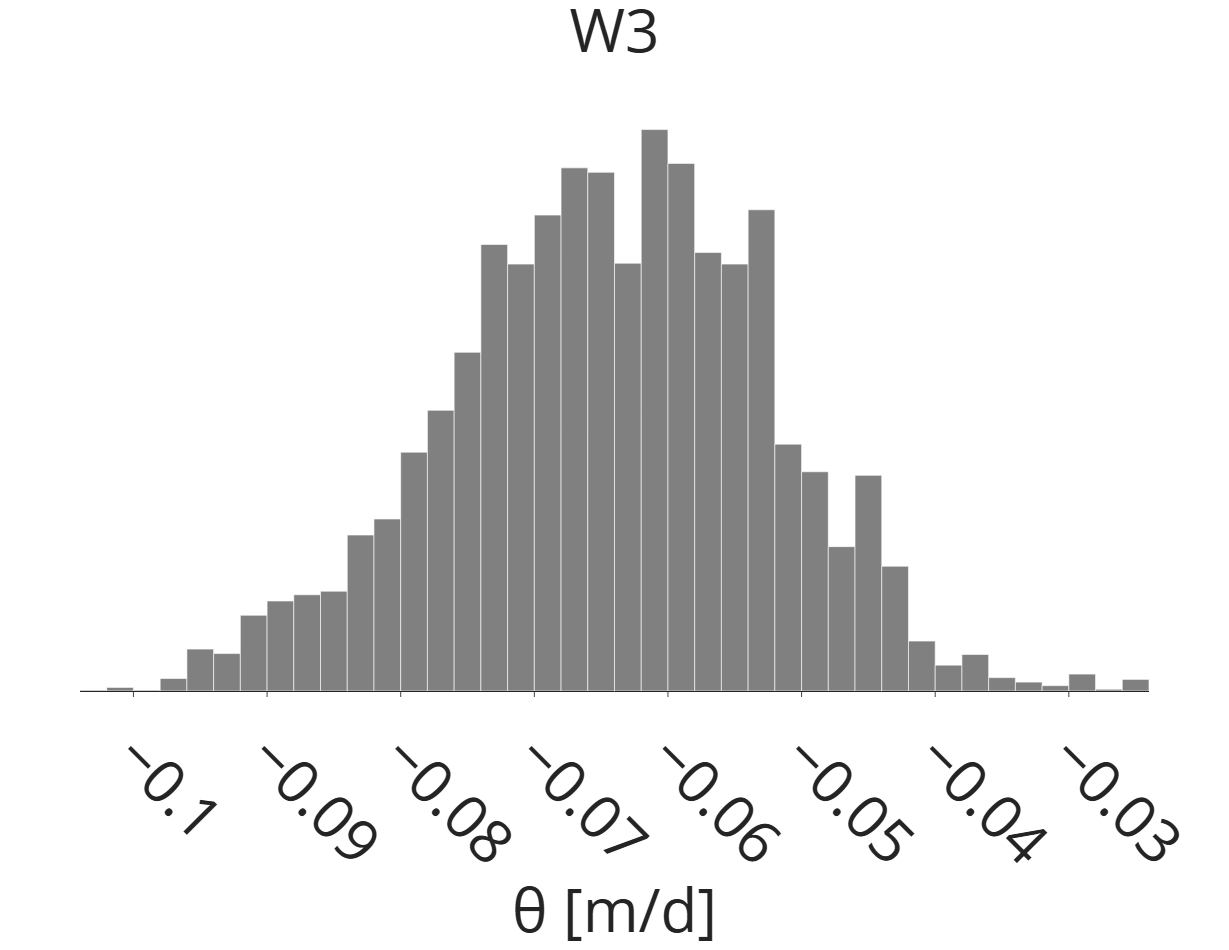

In [15]:
theta_idx = 4

# posterior distribution
fig = go.Figure(data=[go.Histogram(x=trace[0, burn_in:, theta_idx], nbinsx=50, marker_color='grey')])
fig.update_layout(
    title=dict(
        text=f"{param_group[theta_idx]}",
        x=0.5,
        y=0.99,
        font=dict(size=60)
    ),
    xaxis=dict(
        title="θ [m/d]",
        title_font=dict(size=60),
        tickfont=dict(size=60),
        tickangle=45
    ),
    yaxis=dict(
        visible=False
    ),
    template="simple_white",
    width=1100,
    height=950
)
fig.show()
if wq_sensors_used == 'kiosk only':
    fig.write_image(RESULTS_DIR / f'wq/posterior_dists/{param_group[theta_idx]}_{data_period}_{demand_resolution}_kiosk-only_{sim_days}-day_sim.png')
else:
    fig.write_image(RESULTS_DIR / f'wq/posterior_dists/{param_group[theta_idx]}_{data_period}_{demand_resolution}_kiosk+hydrant_{sim_days}-day_sim.png')

# # trace plot
# fig = go.Figure(data=go.Scatter(
#     x=np.arange(0,len(trace[burn_in:, theta_idx])-1),
#     y=trace[burn_in:, theta_idx],
#     mode='markers',
#     marker=dict(size=6, opacity=0.6),
# ))
# fig.update_layout(
#     # title="EPANET vs GP",
#     # xaxis_title="EPANET simulator [mg/L]",
#     # yaxis_title="GP surrogate [mg/L]",
#     template="simple_white",
#     width=550,
#     height=450
# )
# fig.show()

### Verify calibration performance (goodness of fit)

Get mean wall decay coefficients.

In [ ]:
# compute mean parameters
wall_coeffs_mean = trace.mean(axis=0)
wall_coeffs_mean = decision_variables_to_dict(grouping, wall_coeffs_mean)
print(wall_coeffs_mean)

# compute 2.5th percentile parameters
wall_coeffs_025 = np.percentile(trace, 2.5, axis=0)
wall_coeffs_025 = decision_variables_to_dict(grouping, wall_coeffs_025)

# compute 97.5th percentile parameters
wall_coeffs_975 = np.percentile(trace, 97.5, axis=0)
wall_coeffs_975 = decision_variables_to_dict(grouping, wall_coeffs_975)

Run EPANET simulation.

In [ ]:
# reload data
flow_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-flow.csv")
pressure_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-pressure.csv")
wq_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-wq.csv", low_memory=False)
cl_df = wq_df[wq_df['data_type'] == 'chlorine']

# function to build models and run simulations
def run_simulation(flow_df, pressure_df, cl_df, wall_coeffs, sim_type='chlorine', demand_resolution='wwmd', grouping=None):
    wn = build_model(flow_df, pressure_df, cl_df, sim_type=sim_type, demand_resolution=demand_resolution, grouping=grouping, wall_coeffs=wall_coeffs)
    sim_results = epanet_simulator(wn, sim_type, cl_df)
    return sim_results.chlorine

# run simulations for different wall coefficients
cl_sim_mean = run_simulation(flow_df, pressure_df, cl_df, wall_coeffs=wall_coeffs_mean, grouping=grouping)
cl_sim_025 = run_simulation(flow_df, pressure_df, cl_df, wall_coeffs=wall_coeffs_025, grouping=grouping)
cl_sim_975 = run_simulation(flow_df, pressure_df, cl_df, wall_coeffs=wall_coeffs_975, grouping=grouping)

# function to map simulated data to sensor nodes
def map_to_sensors(sim_data, sensor_data):
    name_mapping = sensor_data.set_index('model_id')['bwfl_id'].to_dict()
    sim_data_sensor = sim_data[sensor_data['model_id'].unique()]
    return sim_data_sensor.rename(columns=name_mapping)

# obtain simulated data at sensor nodes
sensor_data = sensor_model_id('wq')
cl_sim_mean_sensor = map_to_sensors(cl_sim_mean, sensor_data)
cl_sim_025_sensor = map_to_sensors(cl_sim_025, sensor_data)
cl_sim_975_sensor = map_to_sensors(cl_sim_975, sensor_data)

# filter sensors in observed data
cl_df_bwfl_ids = cl_df['bwfl_id'].unique()
bwfl_ids = [
    sensor for sensor in sensor_data['bwfl_id'].unique() 
    if sensor in cl_df_bwfl_ids and sensor not in ['BW1', 'BW4']
]

datetime = cl_df['datetime'].unique()

Plot time series comparison.

In [ ]:
# bwfl_ids = [bwfl_id for bwfl_id in wq_df['bwfl_id'].unique() if bwfl_id not in ['BW1', 'BW4']]
bwfl_ids = ['BW1', 'BW2', 'BW3', 'BW4', 'BW5', 'BW6', 'BW7', 'BW9', 'BW12']
subplot_titles = [f"{bwfl_id}" for bwfl_id in bwfl_ids]
fig = make_subplots(rows=len(bwfl_ids), cols=1, subplot_titles=subplot_titles)

y_max = 1.0

for idx, bwfl_id in enumerate(bwfl_ids): 
    data = wq_df[(wq_df['bwfl_id'] == bwfl_id) & (wq_df['data_type'] == 'chlorine')]
    sim_mean = cl_sim_mean_sensor[bwfl_id].values
    sim_025 = cl_sim_025_sensor[bwfl_id].values
    sim_975 = cl_sim_975_sensor[bwfl_id].values
    show_legend = (idx == 0)

    # sensor data
    if wq_sensors_used == 'kiosk only':
        if bwfl_id in ['BW3', 'BW6', 'BW7']:
            dash = 'dot'
        else:
            dash = 'solid'
    elif bwfl_id in ['BW7']:
        dash = 'dot'
    else:
        dash = 'solid'
            
    fig.add_trace(
        go.Scatter(
            x=data['datetime'][96:],
            y=data['mean'][96:],
            mode='lines',
            name='actual',
            line=dict(color='black', dash=dash),
            showlegend=show_legend
        ),
        row=idx + 1, col=1
    )
    
    # simulated data
    if bwfl_id != 'BW7':
        color = color=default_colors[1]
    else:
        color = color=default_colors[5]
        
    fig.add_trace(
        go.Scatter(
            x=data['datetime'][96:],
            y=sim_mean[96:],
            mode='lines',
            name='model',
            line=dict(color=color),
            showlegend=show_legend
        ),
        row=idx + 1, col=1
    )
    
    # add confidence interval
    fig.add_trace(
        go.Scatter(
            x=data['datetime'][96:].tolist() + data['datetime'][96:].tolist()[::-1],
            y=sim_975[96:].tolist() + sim_025[96:].tolist()[::-1],
            fill='toself',
            fillcolor=color,
            opacity=0.2,
            line=dict(color='rgba(0,0,0,0)'),
            name='95% CI',
            showlegend=show_legend
        ),
        row=idx + 1, col=1
    )
    fig.update_yaxes(title_text="Chlorine [mg/L]", rangemode="tozero", range=[0, y_max], row=idx + 1, col=1)

fig.update_layout(
    height=450 * len(bwfl_ids),
    template='simple_white',
    showlegend=False,
    font=dict(size=24),
    title_font=dict(size=24),
    width=800
)
for i in fig['layout']['annotations']:
   i['font'] = dict(size=28)

fig.show()

Parity plots

In [ ]:
fig = make_subplots(rows=len(bwfl_ids), cols=1, subplot_titles=bwfl_ids)

for idx, bwfl_id in enumerate(bwfl_ids):
    row = idx + 1
    col = 1
    
    # get data for this location
    data = wq_df[(wq_df['bwfl_id'] == bwfl_id) & (wq_df['data_type'] == 'chlorine')]
    measured = data['mean'][96:].values
    simulated = cl_sim_mean_sensor[bwfl_id].values[96:]
    
    # calculate max value for axis limits
    max_val = max(max(measured), max(simulated), 1.0)
    
    # add 1:1 line
    fig.add_trace(
        go.Scatter(
            x=[0, max_val],
            y=[0, max_val],
            mode='lines',
            line=dict(color='black', dash='solid'),
            showlegend=False
        ),
        row=row, col=col
    )
    
    # add error bounds
    for offset in [-0.1, 0.1]:
        fig.add_trace(
            go.Scatter(
                x=[0, max_val],
                y=[offset, max_val + offset],
                mode='lines',
                line=dict(color='black', dash='dot'),
                showlegend=False
            ),
            row=row, col=col
        )
    
    # add scatter points
    if bwfl_id != 'BW7':
        color = color=default_colors[1]
    else:
        color = color=default_colors[5]
        
    fig.add_trace(
        go.Scatter(
            x=measured,
            y=simulated,
            mode='markers',
            marker=dict(color=color, size=10, opacity=0.6),
            showlegend=False
        ),
        row=row, col=col
    )
    
    # update axes
    fig.update_xaxes(title_text="Measured [mg/L]", range=[0, max_val], row=row, col=col)
    fig.update_yaxes(title_text="Simulated [mg/L]", range=[0, max_val], row=row, col=col)

# update layout
fig.update_layout(
    height=450 * len(bwfl_ids),
    width=550,
    template='simple_white',
    showlegend=False,
    font=dict(size=24)
)

# update subplot title font sizes
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=28)

fig.show()